In [173]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def to_grayscale(image):
    return np.dot(image[..., :3], [0.2989, 0.5870, 0.1140]).astype(np.uint8)


def threshold(image, thresh_value=128):
    binary_image = np.zeros_like(image)
    binary_image[image > thresh_value] = 255
    return binary_image

def draw_rectangle(image, top_left, width, height, color=(0, 255, 0)):
    x, y = top_left
    image[y, x:x + width] = color
    image[y + height - 1, x:x + width] = color
    image[y:y + height, x] = color
    image[y:y + height, x + width - 1] = color
    return image

def draw_red_dot(image, center, radius=5, color=(0, 0, 255)):
    x, y = center
    for i in range(-radius, radius + 1):
        for j in range(-radius, radius + 1):
            if i**2 + j**2 <= radius**2:
                if 0 <= y + i < image.shape[0] and 0 <= x + j < image.shape[1]:
                    image[y + i, x + j] = color
    return image


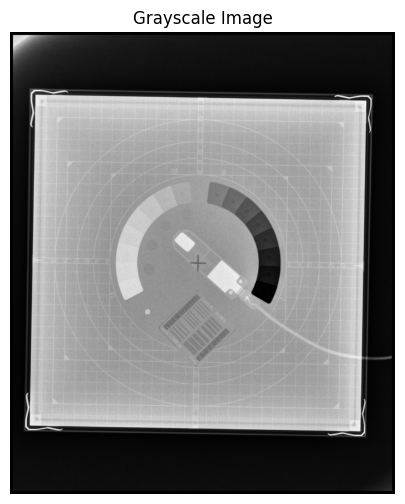

In [174]:
input_image_path = r"PNG\0.8mAs.png"
input_image = cv2.imread(input_image_path)

if input_image is None:
    print("Error: Could not read the image. Please check the path and filename.")
else:
    grayscale_image = to_grayscale(input_image)

    plt.figure(figsize=(6, 6))
    plt.imshow(grayscale_image, cmap='gray')
    plt.title('Grayscale Image')
    plt.axis('off')
    plt.show()


{'top_left': (120, 380)}
{'top_left': (120, 380), 'top_right': (2420, 400)}
{'top_left': (120, 380), 'top_right': (2420, 400), 'bottom_left': (80, 2666)}
{'top_left': (120, 380), 'top_right': (2420, 400), 'bottom_left': (80, 2666), 'bottom_right': (2358, 2695)}


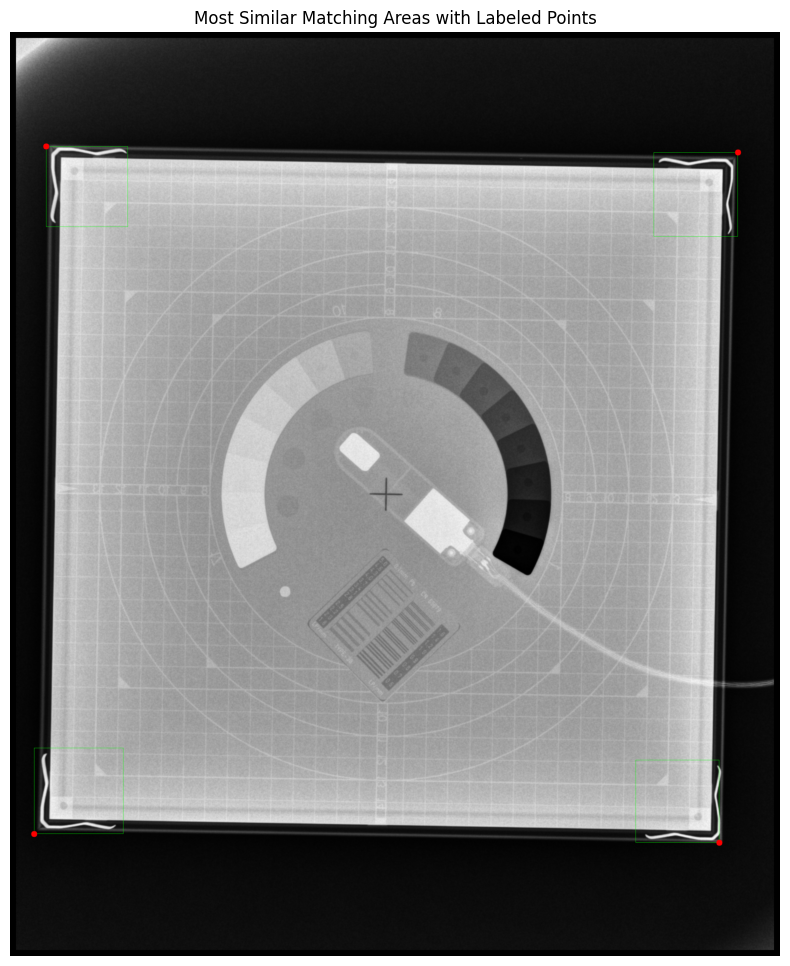

In [158]:

        
import numpy as np
import cv2
import matplotlib.pyplot as plt

input_image = cv2.imread(input_image_path)

kernel_images_info = [
    ("Left_Top_KERNEL.png", "top_left"),
    ("Right_Top_KERNEL.png", "top_right"),
    ("Left_Bottom_KERNEL.png", "bottom_left"),
    ("Right_Bottom_KERNEL.png", "bottom_right")
]

if input_image is None:
    print("Error: Could not read the input image. Please check the path and filename.")
else:
    grayscale_image = np.dot(input_image[..., :3], [0.2989, 0.5870, 0.1140]).astype(np.uint8)
    threshold_value = 128
    binary_image = threshold(grayscale_image, thresh_value=threshold_value)

    output_image = input_image.copy()
    corner_points = {}

    for kernel_image_path, position_type in kernel_images_info:
        kernel_image = cv2.imread(kernel_image_path, cv2.IMREAD_GRAYSCALE)

        if kernel_image is None:
            print(f"Error: Could not read kernel image {kernel_image_path}.")
            continue

        template_height, template_width = kernel_image.shape
        max_similarity = 0.8
        best_match_position = (0, 0)

        step_size = 20
        for y in range(0, binary_image.shape[0] - template_height + 1, step_size):
            for x in range(0, binary_image.shape[1] - template_width + 1, step_size):
                region = binary_image[y:y + template_height, x:x + template_width]
                match_score = np.sum(region == kernel_image) / (template_height * template_width)
                
                if match_score > max_similarity:
                    max_similarity = match_score
                    # print(max_similarity)
                    best_match_position = (x, y)

        if position_type == "top_left":
            point = best_match_position  # top-left corner
        elif position_type == "top_right":
            point = (best_match_position[0] + template_width, best_match_position[1])  # top-right corner
        elif position_type == "bottom_left":
            point = (best_match_position[0], best_match_position[1] + template_height)  # bottom-left corner
        elif position_type == "bottom_right":
            point = (best_match_position[0] + template_width, best_match_position[1] + template_height)  # bottom-right corner

        corner_points[position_type] = point
        print(corner_points)

        output_image = draw_rectangle(output_image, best_match_position, template_width, template_height, color=(0, 255, 0))

        output_image = draw_red_dot(output_image, point, radius=10, color=(0, 0, 255))

    plt.figure(figsize=(12, 12))
    plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
    plt.title('Most Similar Matching Areas with Labeled Points')
    plt.axis('off')
    plt.show()




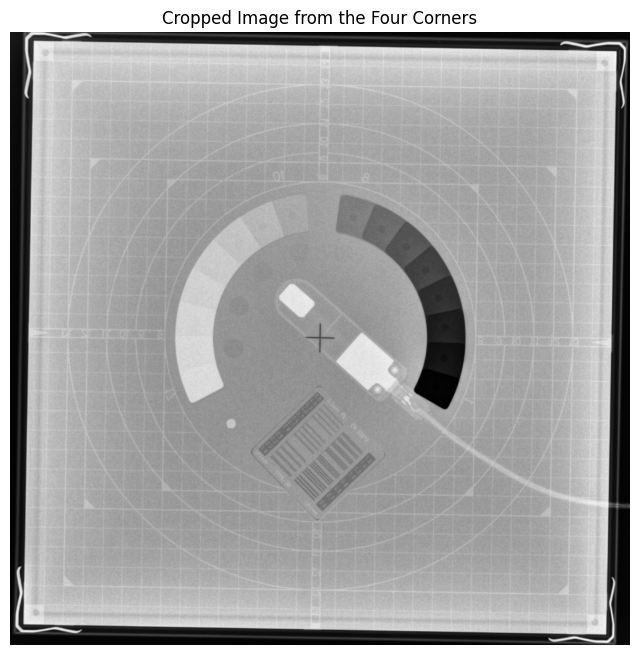

In [159]:
top_left = corner_points['top_left']
top_right = corner_points['top_right']
bottom_left = corner_points['bottom_left']
bottom_right = corner_points['bottom_right']

left_edge = min(top_left[0], bottom_left[0])
right_edge = max(top_right[0], bottom_right[0])
top_edge = min(top_left[1], top_right[1])
bottom_edge = max(bottom_left[1], bottom_right[1])

cropped_image = input_image[top_edge:bottom_edge, left_edge:right_edge]

plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
plt.title('Cropped Image from the Four Corners')
plt.axis('off')
plt.show()


0.49821161261364194


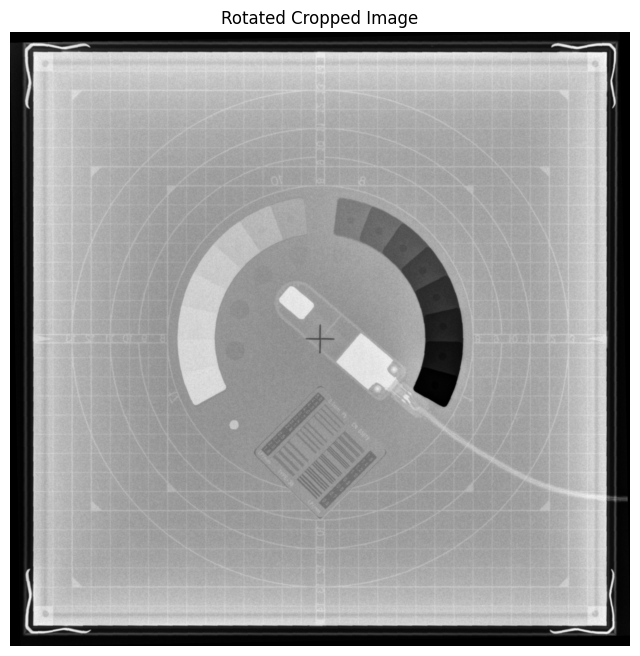

In [160]:
import numpy as np
import matplotlib.pyplot as plt
from math import atan2, degrees, cos, sin

def calculate_rotation_angle(point1, point2):
    delta_y = point2[1] - point1[1]
    delta_x = point2[0] - point1[0]
    angle = atan2(delta_y, delta_x)
    return degrees(angle)

def rotate_image(image, angle):
    (height, width) = image.shape[:2]
    center = (width // 2, height // 2)

    angle_rad = np.deg2rad(angle)
    cos_theta = cos(angle_rad)
    sin_theta = sin(angle_rad)

    new_width = int(abs(height * sin_theta) + abs(width * cos_theta))
    new_height = int(abs(height * cos_theta) + abs(width * sin_theta))

    rotated_image = np.zeros((new_height, new_width, image.shape[2]), dtype=image.dtype)
    offset_x = (new_width - width) // 2
    offset_y = (new_height - height) // 2

    for y in range(new_height):
        for x in range(new_width):
            x_orig = (x - offset_x - center[0]) * cos_theta + (y - offset_y - center[1]) * sin_theta + center[0]
            y_orig = -(x - offset_x - center[0]) * sin_theta + (y - offset_y - center[1]) * cos_theta + center[1]

            if 0 <= x_orig < width and 0 <= y_orig < height:
                rotated_image[y, x] = image[int(y_orig), int(x_orig)]

    return rotated_image

top_left = corner_points['top_left']
top_right = corner_points['top_right']
bottom_left = corner_points['bottom_left']
bottom_right = corner_points['bottom_right']

left_edge = min(top_left[0], bottom_left[0])
right_edge = max(top_right[0], bottom_right[0])
top_edge = min(top_left[1], top_right[1])
bottom_edge = max(bottom_left[1], bottom_right[1])

cropped_image = input_image[top_edge:bottom_edge, left_edge:right_edge]

rotation_angle = calculate_rotation_angle(top_left, top_right)
print(rotation_angle)

rotated_cropped_image = rotate_image(cropped_image, -2*rotation_angle)

plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(rotated_cropped_image, cv2.COLOR_BGR2RGB))
plt.title('Rotated Cropped Image')
plt.axis('off')
plt.show()


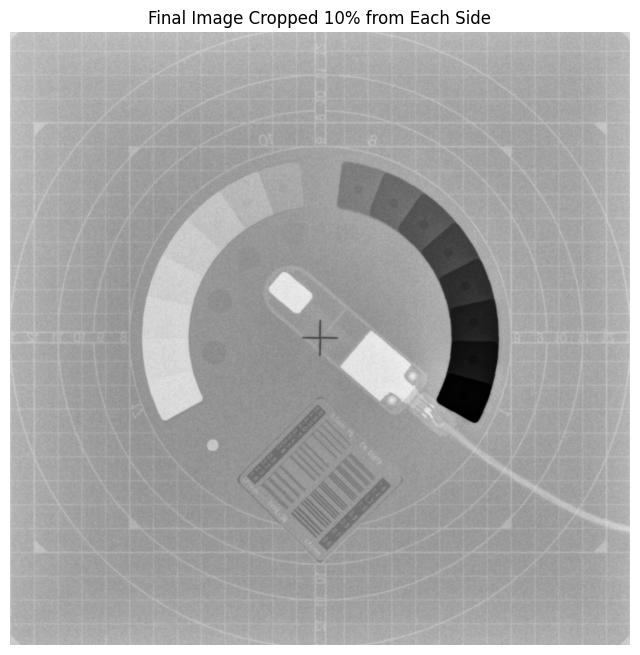

In [161]:
height, width = rotated_cropped_image.shape[:2]
margin_x = int(width * 0.10)
margin_y = int(height * 0.10)

cropped_final_image = rotated_cropped_image[margin_y:height - margin_y, margin_x:width - margin_x]

plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(cropped_final_image, cv2.COLOR_BGR2RGB))
plt.title('Final Image Cropped 10% from Each Side')
plt.axis('off')
plt.show()


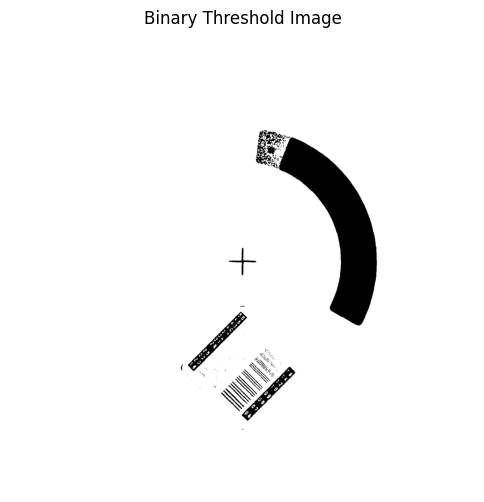

In [162]:
threshold_value = 125
cropped_binary_image = threshold(cropped_final_image, thresh_value=threshold_value)

plt.figure(figsize=(6, 6))
plt.imshow(cropped_binary_image, cmap='gray')
plt.title('Binary Threshold Image')
plt.axis('off')
plt.show()


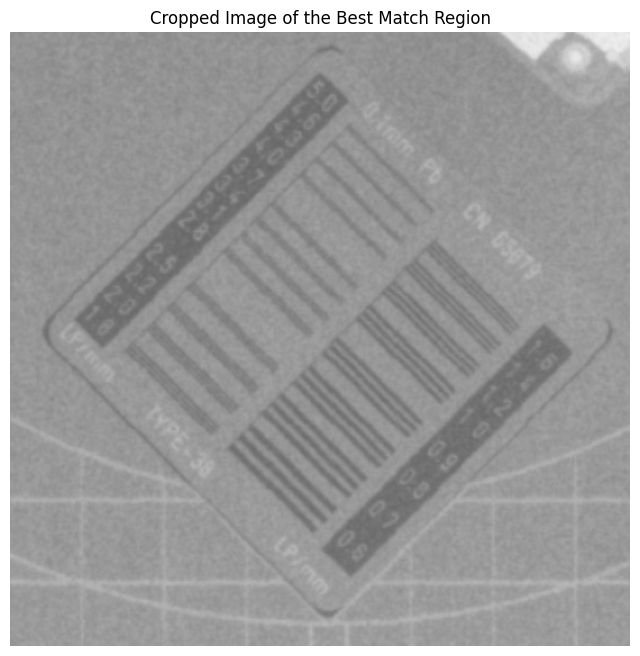

In [163]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


phantom_kernel_path = 'phantom-kernel.png'
phantom_kernel = cv2.imread(phantom_kernel_path)
if phantom_kernel is None:
    print("Error: Could not read the phantom kernel image. Please check the path and filename.")
else:
    phantom_kernel_gray = to_grayscale(phantom_kernel)
    cropped_binary_image = to_grayscale(cropped_binary_image)

    template_height, template_width = phantom_kernel_gray.shape
    max_similarity = -1
    best_match_position = None

    step_size = 10
    for y in range(0, cropped_binary_image.shape[0] - template_height + 1, step_size):
        for x in range(0, cropped_binary_image.shape[1] - template_width + 1, step_size):
            region = cropped_binary_image[y:y + template_height, x:x + template_width]

            match_score = np.sum(region == phantom_kernel_gray) / (template_height * template_width)

            if match_score > max_similarity:
                max_similarity = match_score
                best_match_position = (x, y)

    if best_match_position is not None:
        x_best, y_best = best_match_position

        cropped_best_match = cropped_final_image[y_best:y_best + template_height, x_best:x_best + template_width]

        plt.figure(figsize=(8, 8))
        plt.imshow(cv2.cvtColor(cropped_best_match, cv2.COLOR_BGR2RGB))
        plt.title('Cropped Image of the Best Match Region')
        plt.axis('off')
        plt.show()
    else:
        print("No matching regions found.")


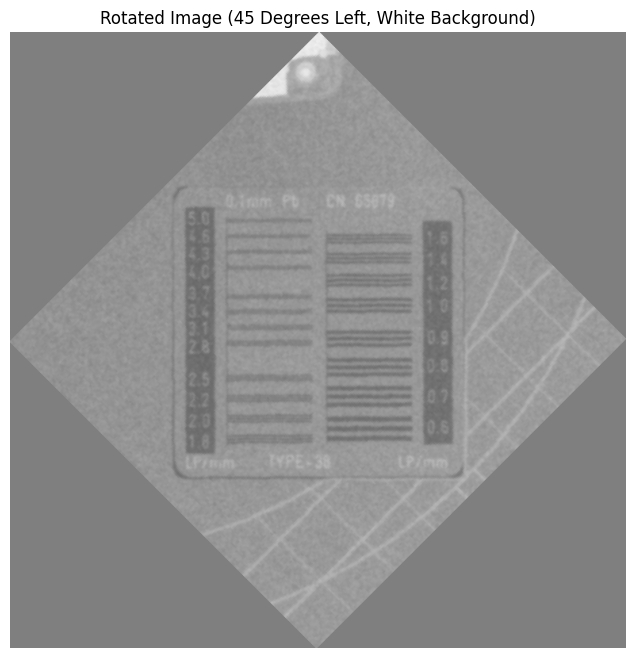

In [164]:
import numpy as np
import matplotlib.pyplot as plt
from math import cos, sin, radians

def rotate_image(image, angle):
    angle_rad = radians(angle)
    cos_theta = cos(angle_rad)
    sin_theta = sin(angle_rad)
    
    (h, w) = image.shape[:2]

    new_w = int(abs(h * sin_theta) + abs(w * cos_theta))
    new_h = int(abs(h * cos_theta) + abs(w * sin_theta))

    center_x, center_y = w // 2, h // 2

    rotated_image = np.ones((new_h, new_w, image.shape[2]), dtype=image.dtype) * 127

    new_center_x, new_center_y = new_w // 2, new_h // 2

    for y in range(new_h):
        for x in range(new_w):
            x_shifted = x - new_center_x
            y_shifted = y - new_center_y

            orig_x = int(center_x + (x_shifted * cos_theta + y_shifted * sin_theta))
            orig_y = int(center_y + (-x_shifted * sin_theta + y_shifted * cos_theta))

            if 0 <= orig_x < w and 0 <= orig_y < h:
                rotated_image[y, x] = image[orig_y, orig_x]

    return rotated_image

rotated_cropped_image = rotate_image(cropped_best_match, angle=-45)

plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(rotated_cropped_image, cv2.COLOR_BGR2RGB))
plt.title('Rotated Image (45 Degrees Left, White Background)')
plt.axis('off')
plt.show()


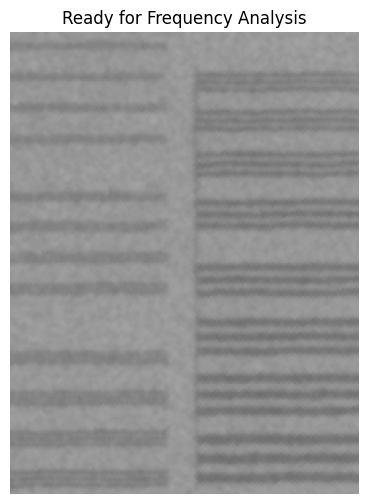

In [175]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

image = rotated_cropped_image.copy()
clone = image.copy()

start_point = None
end_point = None
drawing = False

def draw_rectangle(event, x, y, flags, param):
    global start_point, end_point, drawing, image

    if event == cv2.EVENT_LBUTTONDOWN:
        start_point = (x, y)
        drawing = True

    elif event == cv2.EVENT_MOUSEMOVE:
        if drawing:
            image = clone.copy()
            cv2.rectangle(image, start_point, (x, y), (0, 255, 0), 2)
            cv2.imshow("Select Rectangle to Crop", image)

    elif event == cv2.EVENT_LBUTTONUP:
        end_point = (x, y)
        drawing = False
        image = clone.copy()
        cv2.rectangle(image, start_point, end_point, (0, 255, 0), 2)
        cv2.imshow("Select Rectangle to Crop", image)
        crop_image_by_rectangle(start_point, end_point)

def crop_image_by_rectangle(start, end):
    global image
    x1, y1 = start
    x2, y2 = end

    x_min = min(x1, x2)
    x_max = max(x1, x2)
    y_min = min(y1, y2)
    y_max = max(y1, y2)

    cropped = clone[y_min:y_max, x_min:x_max]

    cv2.imshow("Cropped Image", cropped)
    cv2.waitKey(1000)

    cv2.destroyAllWindows()

    cropped_image_path = "ready_to_freq_analysis.png"
    cv2.imwrite(cropped_image_path, cropped)

    plot_image_in_jupyter(cropped_image_path)

def plot_image_in_jupyter(image_path):
    cropped_image = cv2.imread(image_path)
    cropped_image_rgb = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(6, 6))
    plt.imshow(cropped_image_rgb)
    plt.title("Ready for Frequency Analysis")
    plt.axis('off')
    plt.show()

cv2.imshow("Select Rectangle to Crop", image)
cv2.setMouseCallback("Select Rectangle to Crop", draw_rectangle)

cv2.waitKey(0)
cv2.destroyAllWindows()


# SMOOTHING DENENDI AMA BOZUYOR

In [166]:
import cv2
import numpy as np

def smooth_image(image_path, kernel_size=3):
    """Apply smoothing (mean filter) to an image and save it."""
    # Read the image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Padding the image to handle borders
    pad_size = kernel_size // 2
    padded_image = np.pad(image, ((pad_size, pad_size), (pad_size, pad_size)), mode='constant', constant_values=0)
    
    # Create an empty array for the smoothed image
    smoothed_image = np.zeros_like(image)
    
    # Apply the mean filter
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            # Extract the kernel region
            kernel_region = padded_image[i:i + kernel_size, j:j + kernel_size]
            # Calculate the mean value
            mean_value = np.mean(kernel_region)
            # Assign the mean value to the smoothed image
            smoothed_image[i, j] = int(mean_value)
    
    # Construct the new file name
    file_name_parts = image_path.split('.')
    base_name = '.'.join(file_name_parts[:-1])
    extension = file_name_parts[-1]
    new_file_name = f"{base_name}_smoothed_{kernel_size}x{kernel_size}.{extension}"
    
    # Save the smoothed image
    cv2.imwrite(new_file_name, smoothed_image)
    print(f"Smoothed image saved as: {new_file_name}")

# Example usage
smooth_image('ready_to_freq_analysis.png', kernel_size=3)  # Smooth the image with a 5x5 kernel


Smoothed image saved as: ready_to_freq_analysis_smoothed_3x3.png


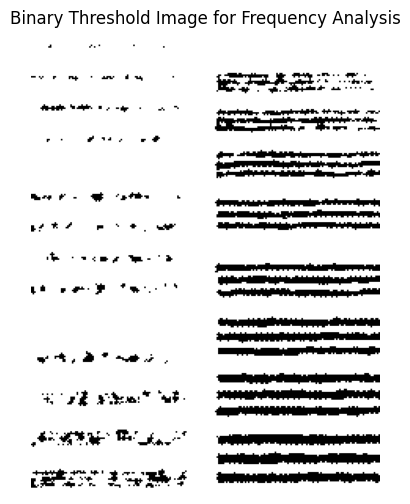

In [176]:
image_path = "ready_to_freq_analysis.png"
cropped_image = cv2.imread(image_path)
cropped_image_gray = to_grayscale(cropped_image)

threshold_value = 128
binary_image = threshold(cropped_image_gray, thresh_value=threshold_value)

plt.figure(figsize=(6, 6))
plt.imshow(binary_image, cmap='gray')
plt.title('Binary Threshold Image for Frequency Analysis')
plt.axis('off')
plt.show()


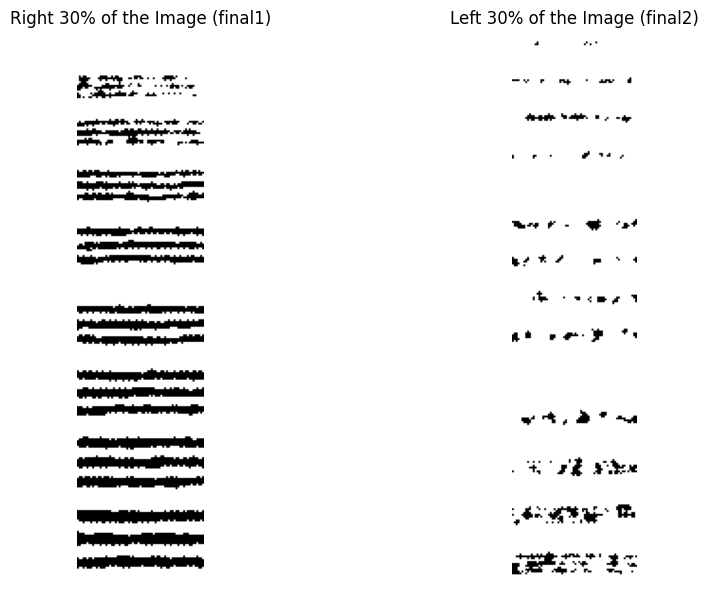

In [168]:
height, width = binary_image.shape

right_start = int(width * 0.7)
left_end = int(width * 0.3)

final1 = binary_image[:, right_start:width]
cv2.imwrite('final1.png', final1)

final2 = binary_image[:, :left_end]
cv2.imwrite('final2.png', final2)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(final1, cmap='gray')
plt.title('Right 30% of the Image (final1)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(final2, cmap='gray')
plt.title('Left 30% of the Image (final2)')
plt.axis('off')

plt.tight_layout()
plt.show()


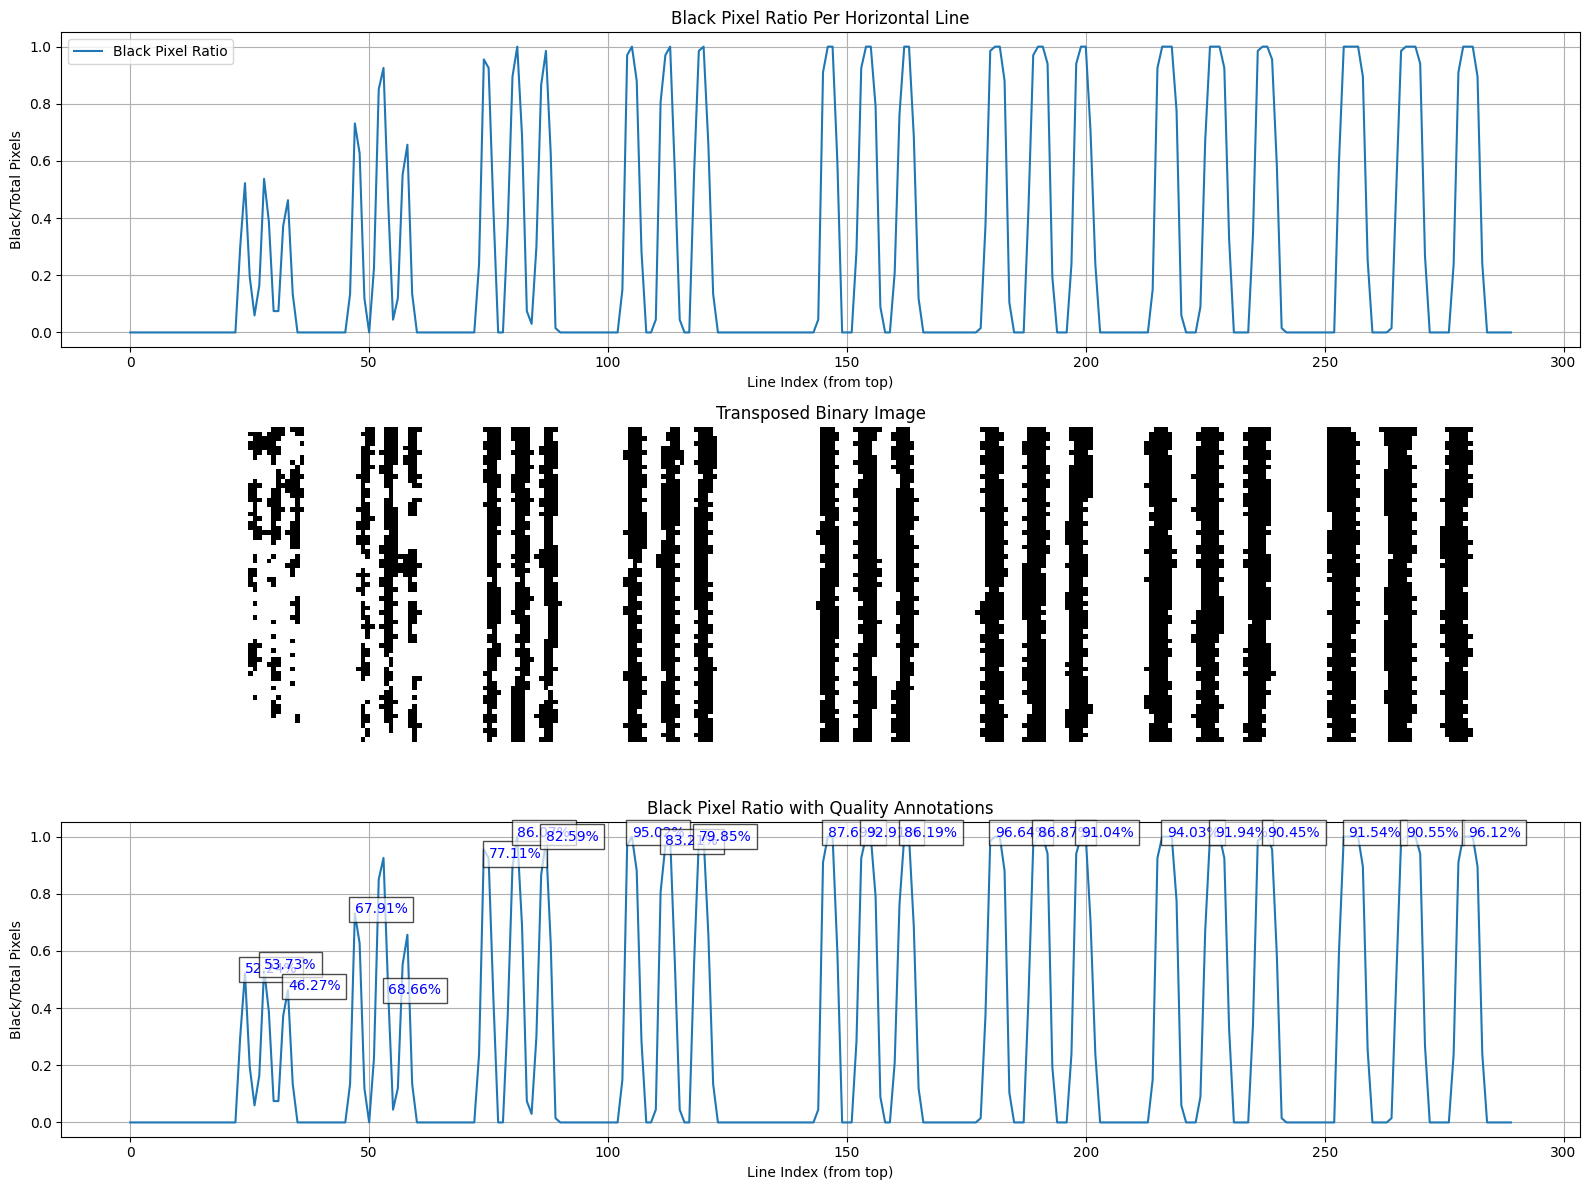

In [177]:
import numpy as np
import matplotlib.pyplot as plt

def analyze_image_with_quality(image_path, threshold=0.4, max_distance=3):
    image = plt.imread(image_path)
    if image.ndim == 3:
        image = to_grayscale(image)

    binary_image = image

    height, width = binary_image.shape
    ratios = []
    for row in range(height):
        total_pixels = width
        black_pixels = np.sum(binary_image[row] == 0)
        ratio = black_pixels / total_pixels
        ratios.append(ratio)

    indices = [i for i, value in enumerate(ratios) if value > threshold]

    groups = []
    if indices:
        current_group = [indices[0]]
        for i in range(1, len(indices)):
            if indices[i] - indices[i - 1] <= max_distance:
                current_group.append(indices[i])
            else:
                groups.append(current_group)
                current_group = [indices[i]]
        groups.append(current_group)

    quality_results = []
    for group in groups:
        mean_value = np.mean([ratios[i] for i in group])
        quality_results.append((group, mean_value * 100))

    transposed_image = binary_image.T

    fig, ax = plt.subplots(3, 1, figsize=(16, 12))

    ax[0].plot(range(len(ratios)), ratios, label="Black Pixel Ratio")
    ax[0].set_title("Black Pixel Ratio Per Horizontal Line")
    ax[0].set_xlabel("Line Index (from top)")
    ax[0].set_ylabel("Black/Total Pixels")
    ax[0].legend()
    ax[0].grid()

    ax[1].imshow(transposed_image, cmap='gray')
    ax[1].set_title('Transposed Binary Image')
    ax[1].axis('off')

    ax[2].plot(range(len(ratios)), ratios, label="Black Pixel Ratio")
    for group, mean_percentage in quality_results:
        center_x = int(np.mean(group))
        if 0 <= center_x < len(ratios):
            ax[2].text(
                center_x,
                ratios[center_x],
                f"{mean_percentage:.2f}%",
                color="blue",
                fontsize=10,
                bbox=dict(facecolor="white", alpha=0.7)
            )
    ax[2].set_title("Black Pixel Ratio with Quality Annotations")
    ax[2].set_xlabel("Line Index (from top)")
    ax[2].set_ylabel("Black/Total Pixels")
    ax[2].grid()

    plt.tight_layout()
    plt.show()

    return ratios, quality_results


ratios, quality_results = analyze_image_with_quality('final1.png')



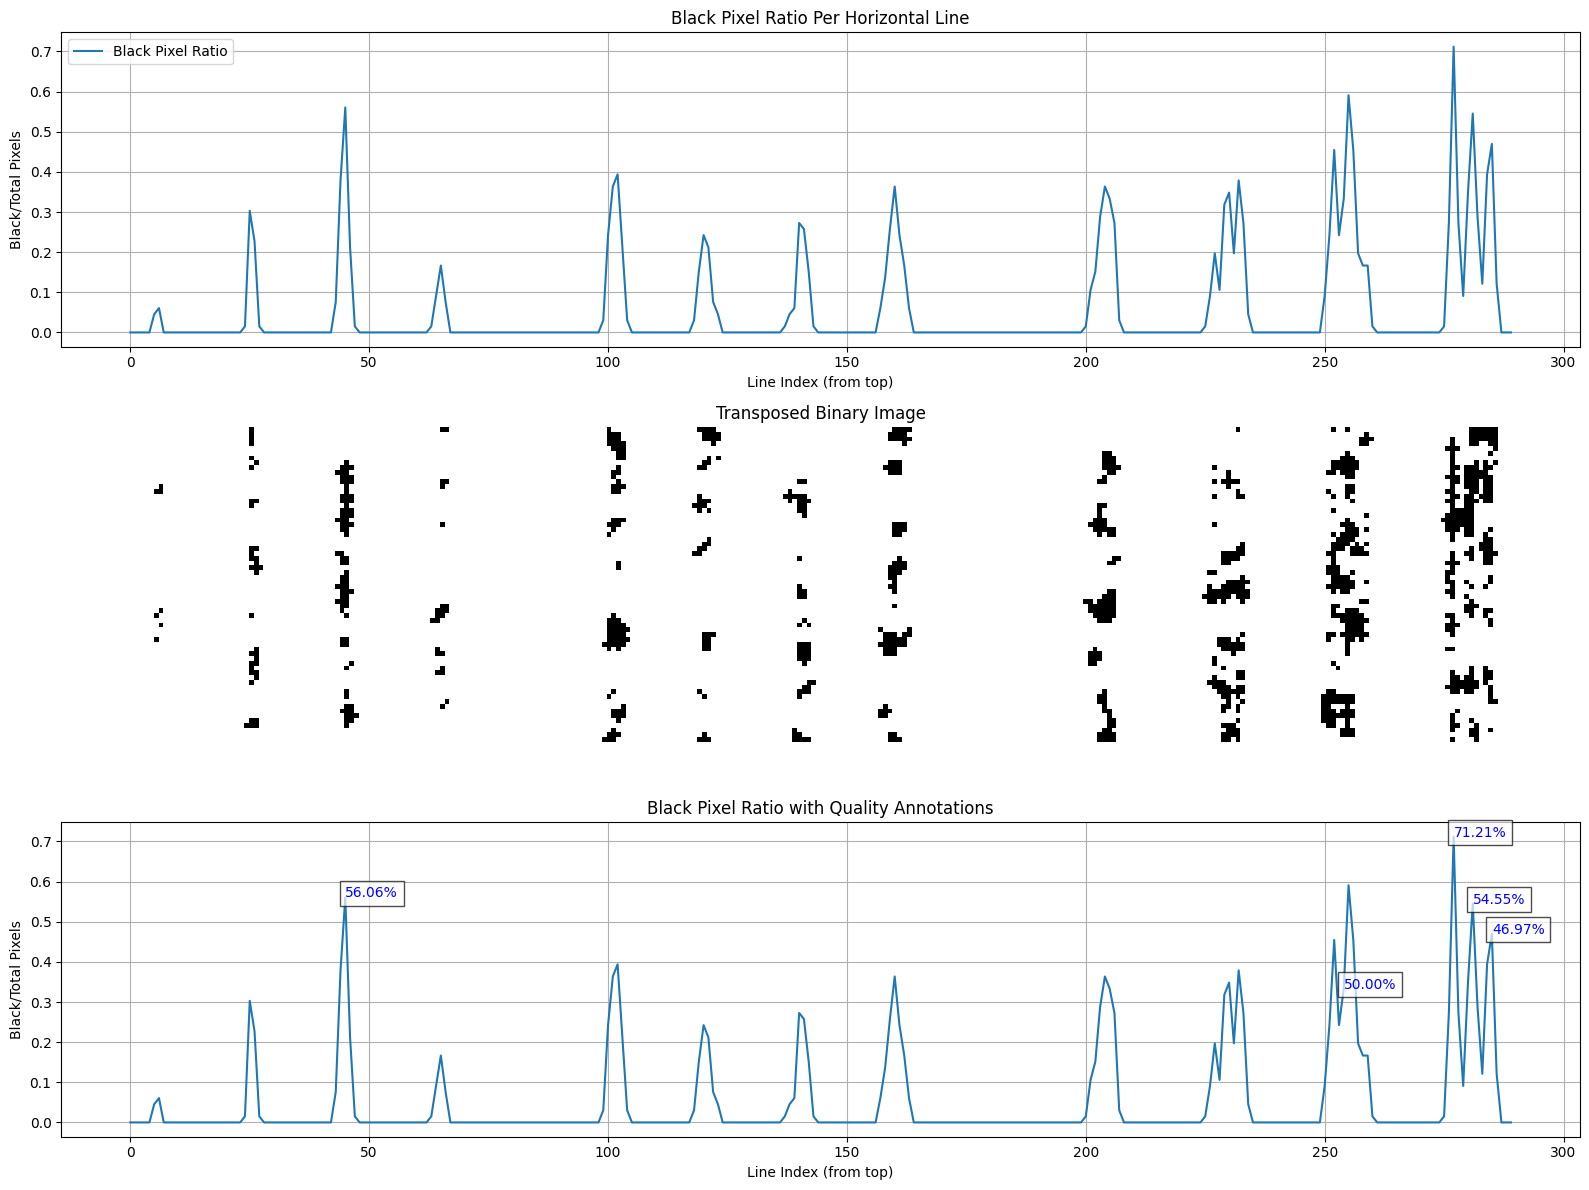

In [170]:
ratios, quality_results = analyze_image_with_quality('final2.png')


In [171]:
import cv2
import numpy as np

def resize_image(image_path, resize_rate):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    new_height = int(image.shape[0] * resize_rate)
    new_width = int(image.shape[1] * resize_rate)

    if new_height < 1 or new_width < 1:
        raise ValueError("Resize rate is too small, resulting in invalid dimensions.")
    if new_height > 10000 or new_width > 10000:
        raise ValueError("Resize rate is too large, resulting in excessively large dimensions.")

    resized_image = np.zeros((new_height, new_width), dtype=np.uint8)

    for i in range(new_height):
        for j in range(new_width):
            orig_i = min(int(i / resize_rate), image.shape[0] - 1)
            orig_j = min(int(j / resize_rate), image.shape[1] - 1)
            resized_image[i, j] = image[orig_i, orig_j]

    file_name_parts = image_path.split('.')
    base_name = '.'.join(file_name_parts[:-1])
    extension = file_name_parts[-1]
    new_file_name = f"{base_name}_resized_rate_{resize_rate:.1f}.{extension}"

    cv2.imwrite(new_file_name, resized_image)
    print(f"Resized image saved as: {new_file_name}")


def erode(image, kernel):
    """Performs erosion on the binary image."""
    kernel_height, kernel_width = kernel.shape
    padded_image = np.pad(image, ((kernel_height // 2, kernel_height // 2), (kernel_width // 2, kernel_width // 2)), mode='constant', constant_values=0)
    eroded_image = np.zeros_like(image)

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            region = padded_image[i:i + kernel_height, j:j + kernel_width]
            if np.all(region == kernel): 
                eroded_image[i, j] = 255

    return eroded_image

def dilate(image, kernel):
    """Performs dilation on the binary image."""
    kernel_height, kernel_width = kernel.shape
    padded_image = np.pad(image, ((kernel_height // 2, kernel_height // 2), (kernel_width // 2, kernel_width // 2)), mode='constant', constant_values=0)
    dilated_image = np.zeros_like(image)

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            region = padded_image[i:i + kernel_height, j:j + kernel_width]
            if np.any(region == kernel):
                dilated_image[i, j] = 255

    return dilated_image

def process_image(input_path, output_path):
    """Reads the input image, performs erosion and dilation, and saves the result."""
    image = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)

    kernel = np.ones((3, 3), dtype=np.uint8) * 255

    eroded_image = erode(image, kernel)

    dilated_image = dilate(eroded_image, kernel)

    cv2.imwrite(output_path, dilated_image)

process_image('final1.png', 'final1_v2.png')


Resized image saved as: final1_resized_rate_3.0.png


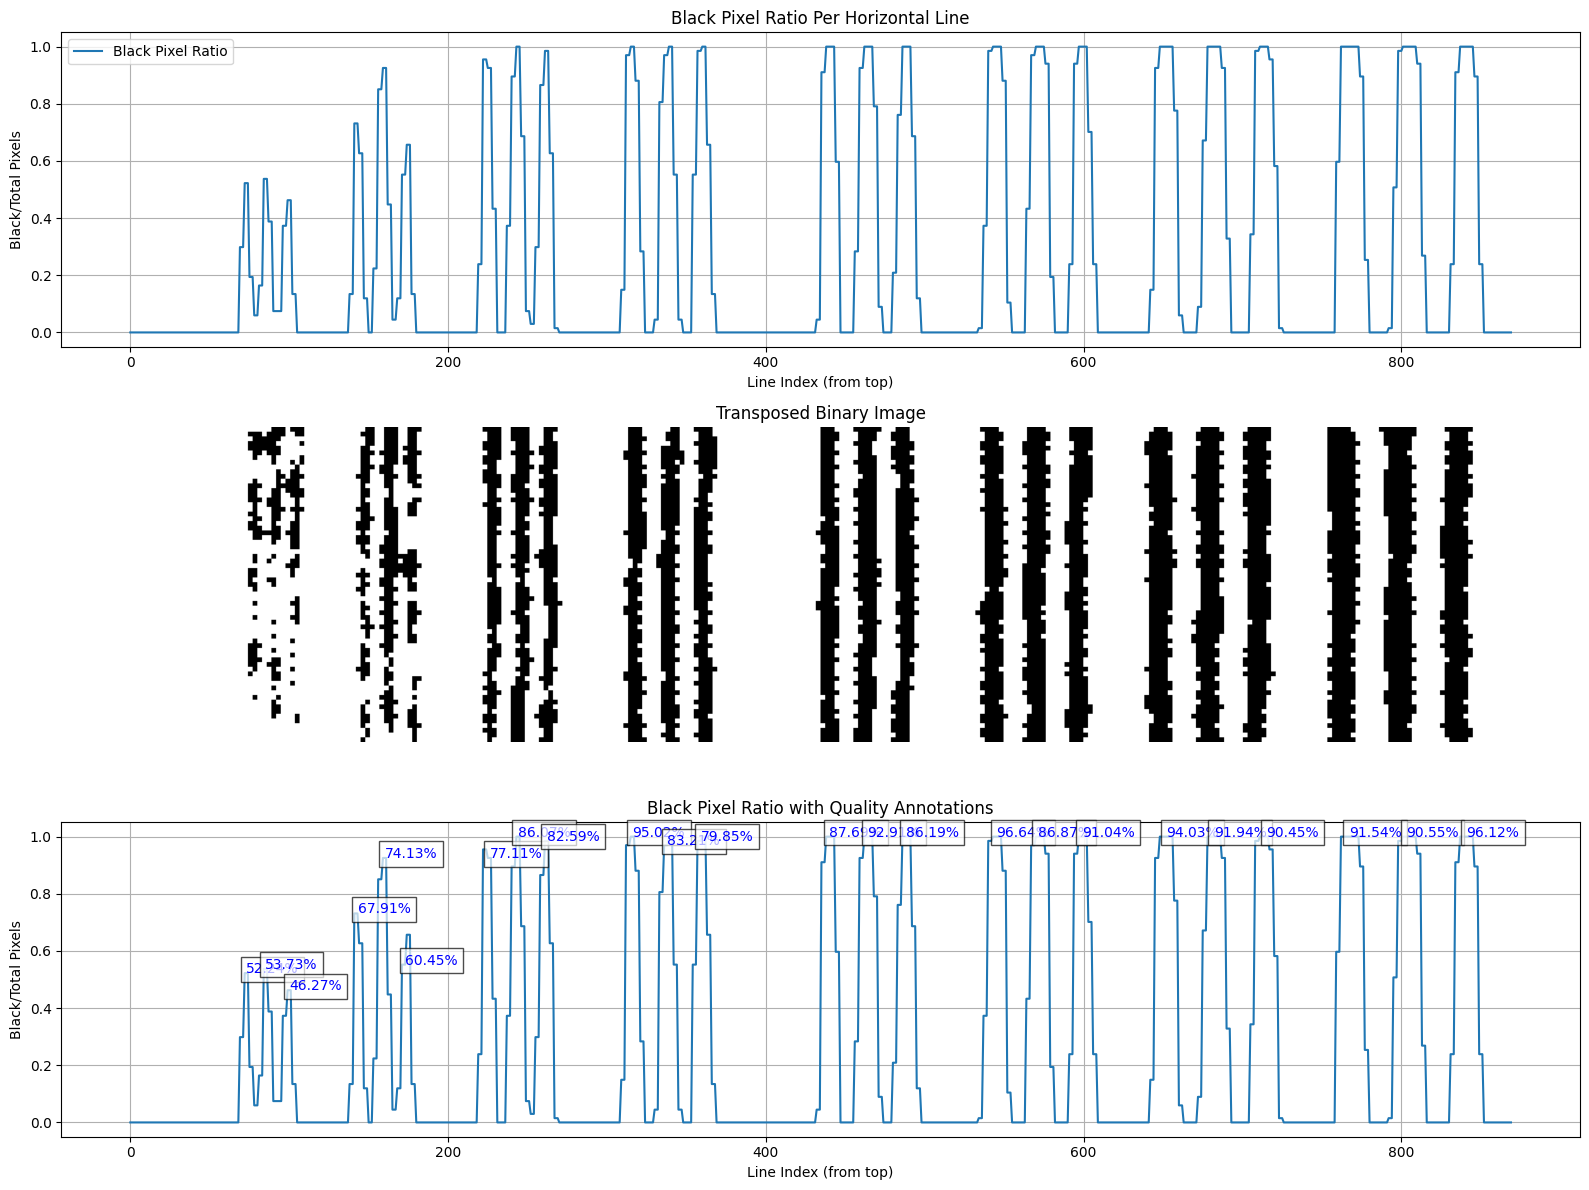

In [172]:

resize_image('final1.png', 3)
process_image('final1_resized_rate_3.0.png', 'final1_v2.png')
ratios, quality_results = analyze_image_with_quality('final1_v2.png')
